# **CNN Practice Exercise: Classifying Chest X-ray Image**

## 1. Data Gathering

1. The dataset for this activity was given by the instructor.
2. The dataset was uploaded to the google drive of the user.
3. The dataset is accessed through mounting the google drive in this notebook.

## 2. Data Preparation

1. The libaries that will be used for this activity are identified in this section.
2. The dataset given for this activity will be processed and analyze for the next following steps.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
image_size = (180, 180)
batch_size = 32


In [3]:
#accessing the data for training
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/COE 005/COVID19/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 249 files belonging to 3 classes.
Using 200 files for training.


In [4]:
#accessing the data for testing
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/COE 005/COVID19/test",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 65 files belonging to 3 classes.
Using 13 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['Covid', 'Normal', 'Viral Pneumonia']


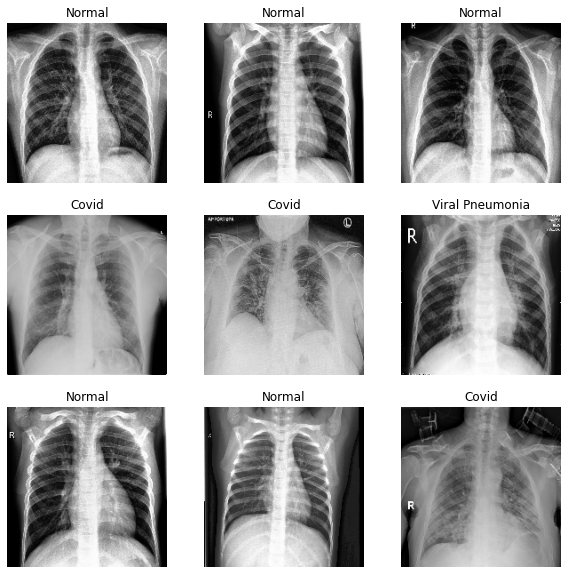

In [6]:
#data visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.05),
     layers.experimental.preprocessing.RandomZoom(0.10)
    ]
)

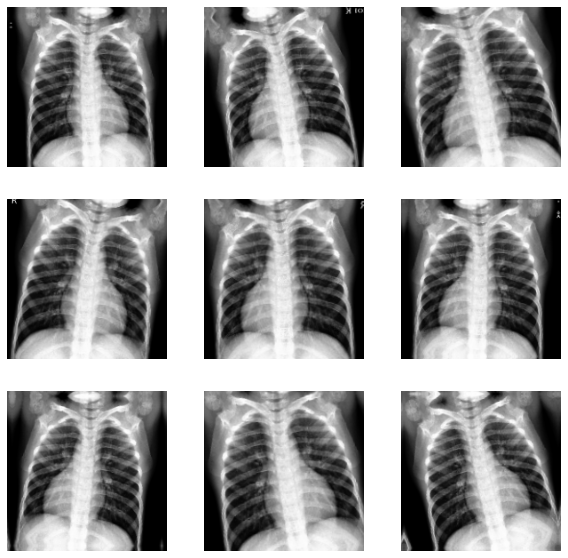

In [8]:
#visualization after augmenting image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## 3. Choosing a Model

1. CNN model is used for the processing of images

In [10]:
#cnn model
keras.backend.clear_session()
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 5, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Conv2D(64, 5, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    for size in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 5, padding="same")(x)
        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Dropout(0.5)(x)
    x = layers.SeparableConv2D(724, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [11]:
def scheduler(epoch, lr):
  if epoch < 9:
    return lr
  else:
    return lr * tf.math.exp(-0.008)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [12]:
model = make_model(input_shape=image_size + (3,), num_classes=3)

## 4. Data Training

1. The processed images will be trained in this section to predict and validate other related images

In [13]:
#increasing the number of epochs yields to better accuracy
epochs = 100

model.compile(optimizer= keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy', metrics = ["accuracy"])

history = model.fit(
    train_ds, epochs = epochs, 
    callbacks = [lr_callback],
    validation_data = val_ds)

Epoch 1/100
7/7 [==============================] - 29s 3s/step - loss: 1.6211 - accuracy: 0.3850 - val_loss: 1.0989 - val_accuracy: 0.2308 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - 21s 2s/step - loss: 1.0981 - accuracy: 0.3750 - val_loss: 1.0966 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - 22s 3s/step - loss: 1.0939 - accuracy: 0.4500 - val_loss: 1.0932 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - 21s 2s/step - loss: 1.0880 - accuracy: 0.4250 - val_loss: 1.0861 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 5/100
7/7 [==============================] - 20s 2s/step - loss: 1.0807 - accuracy: 0.4650 - val_loss: 1.0861 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 6/100
7/7 [==============================] - 20s 2s/step - loss: 1.0735 - accuracy: 0.4050 - val_loss: 1.0832 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 7/100
7/7 [==============================] - 20s 2s/step - loss: 1.0324 - accuracy

## 5. Evaluation

1. The trained data will be evaluated in this section
2. The data will be evaluated by visualizing it through graphs

In [14]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Text(0.5, 1.0, 'Training and Testing Accuracy')

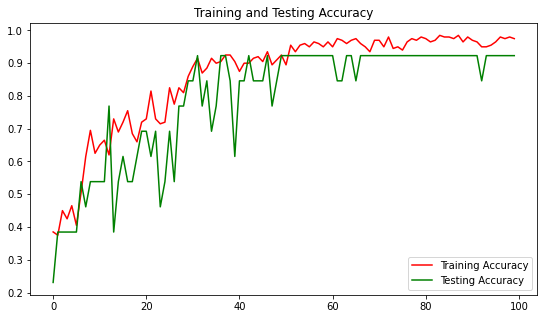

In [16]:
#visualizing the accuracy of training data and testing data
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, color='red', label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, color='green', label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy')

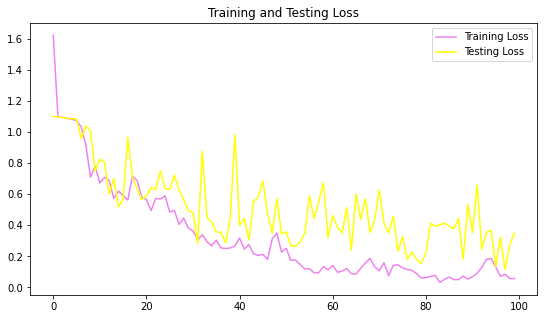

In [17]:
#visualizing the accuracy loss of training data and testing data
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, color='violet', label='Training Loss')
plt.plot(epochs_range, val_loss, color='yellow', label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training and Testing Loss')
plt.show()

## 6. Prediction

1. In this stage, the dataset in the validation will be used for predicting its classification

In [18]:
#assigning variables for the images in validation directory
image_path1 = "/content/drive/My Drive/COE 005/COVID19/validation/pic1.jpeg"
image_path2 = "/content/drive/My Drive/COE 005/COVID19/validation/pic2.jpeg"
image_path3 = "/content/drive/My Drive/COE 005/COVID19/validation/pic3.jpeg"
image_path4 = "/content/drive/My Drive/COE 005/COVID19/validation/pic4.jpeg"
image_path5 = "/content/drive/My Drive/COE 005/COVID19/validation/pic5.jpeg"
image_path6 = "/content/drive/My Drive/COE 005/COVID19/validation/pic6.jpeg"
image_path7 = "/content/drive/My Drive/COE 005/COVID19/validation/pic7.jpg"
image_path8 = "/content/drive/My Drive/COE 005/COVID19/validation/pic8.jpeg"
image_path9 = "/content/drive/My Drive/COE 005/COVID19/validation/pic9.jpeg"
image_path10 = "/content/drive/My Drive/COE 005/COVID19/validation/pic10.jpeg"

merged_path = [image_path1,image_path2,image_path3,image_path4,image_path5,image_path6,image_path7,image_path8,image_path9,image_path10]

In [25]:
#predicting the classification of the image
for img_path in merged_path:
    img = keras.preprocessing.image.load_img(
        img_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(class_names[np.argmax(score)])
        

1/1 [==============================] - 0s 110ms/step
Normal
1/1 [==============================] - 0s 43ms/step
Covid
1/1 [==============================] - 0s 53ms/step
Viral Pneumonia
1/1 [==============================] - 0s 44ms/step
Viral Pneumonia
1/1 [==============================] - 0s 43ms/step
Normal
1/1 [==============================] - 0s 46ms/step
Covid
1/1 [==============================] - 0s 46ms/step
Covid
1/1 [==============================] - 0s 48ms/step
Viral Pneumonia
1/1 [==============================] - 0s 52ms/step
Covid
1/1 [==============================] - 0s 44ms/step
Normal
